In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import statsmodels.formula.api as smf

from matplotlib import pyplot as plt

# Import data

This data comes from here: https://www.nature.com/articles/nbt.3418

In [4]:
df = pd.ExcelFile(r'../Data/raw_data/41587_2016_BFnbt3418_MOESM18_ESM.xlsx')

## Basic metadata clean up and data subsetting

In [79]:
meta_df = df.parse('Table S23', header=2)
meta_df = meta_df[meta_df['Strain'] == 'BW25113']
meta_df['Growth rate (h-1)'][meta_df['Growth condition'].str.contains('Stationary phase')] = 0.0
meta_df = meta_df.sort_values(by=['Growth condition'])
meta_df.rename(columns={'Growth rate (h-1)':'Growth Rate (1/hr)'}, inplace=True)
print(meta_df.shape)
meta_df = meta_df[meta_df['Growth Rate (1/hr)'] > 0]
print(meta_df.shape)
meta_df.head()

(22, 12)
(20, 12)


,Growth condition,Strain,Growth Rate (1/hr),Stdev,Single cell volume [fl]1,Doubling time (h-1),Time exp before harvest (h),# of doublings at exponential growth before harvesting,OD @ harvesting. replicates,Unnamed: 9,Unnamed: 10,Number of Proteins Identified (FDR 1%)2
18,42°C glucose,BW25113,0.66,0.020,2.979732,1,6,5.7,1.53,1.20,1.35,1560.0
4,Acetate,BW25113,0.30,0.040,2.295300,2.3,29.3,12.7,0.53,0.22,0.48,1683.0
14,Fructose,BW25113,0.65,0.004,2.962575,1.1,5,4.7,0.77,0.68,0.77,1612.0
5,Fumarate,BW25113,0.42,0.020,2.538708,1.7,25.4,15.2,0.22,0.20,0.14,1696.0
6,Galactose,BW25113,0.26,0.003,2.210772,2.7,52.1,19.2,2.02,2.03,2.02,1650.0


## And the same for the expression data

In [80]:
exp_df = df.parse('Table S6', header=2, index_col='Gene')
remove_cols1 = exp_df.iloc[:, 28:].columns.tolist()
remove_cols2 = ['Uniprot Accession', 'Description', 'Peptides.used.for.quantitation', 'Confidence.score', 'Molecular weight (Da)', 'Dataset']
remove_cols = remove_cols1 + remove_cols2

exp_df = exp_df.drop(columns=remove_cols)
print(exp_df.shape)
#Should we drop NaNs?
exp_df = exp_df.dropna()
#Removing duplicates
exp_df = exp_df[~exp_df.index.duplicated(keep=False)]
print(exp_df.shape)
exp_df.head()

(2359, 22)
(2052, 22)


,Glucose,LB,Glycerol + AA,Acetate,Fumarate,Glucosamine,Glycerol,Pyruvate,Chemostat µ=0.5,Chemostat µ=0.35,...,Stationary phase 1 day,Stationary phase 3 days,Osmotic-stress glucose,42°C glucose,pH6 glucose,Xylose,Mannose,Galactose,Succinate,Fructose
Gene,,,,,,,,,,,,,,,,,,,,,
rpoC,2778.519359,7164.365261,4503.008971,2179.987893,2444.360952,3315.670480,2844.543315,2729.853857,4780.473046,3900.470038,...,1734.813718,1907.402304,2247.844772,3985.374673,3339.350980,3631.530693,3401.439200,2258.169809,2764.093478,4516.849523
rpoB,3957.434464,8888.466379,5198.560850,2661.253272,3198.783333,3999.083577,3748.809939,3714.432333,5244.783448,4388.325065,...,2378.505976,2226.871744,3253.953113,4922.674021,4031.662066,4437.013516,4142.901444,2820.449491,3855.147645,5269.436583
acnB,7595.542046,16599.719405,17548.341931,22843.967449,19491.484058,13752.781384,10792.191853,16395.219689,15733.209919,20261.123449,...,933.302266,756.478368,2814.510432,4841.834921,4648.925392,6697.447166,16516.920057,12875.302404,19547.132064,8782.370172
purL,2456.265985,820.685737,2339.023495,1437.660376,2071.498566,1958.940131,2067.728776,2708.097340,2285.246876,1730.342352,...,617.662034,734.877414,1318.125833,1885.490251,1708.222151,1720.754608,1764.284838,1570.497687,1913.471944,2405.721350
gltB,2858.930632,604.305858,651.951059,1362.610998,1280.730747,1977.280635,2203.878713,1690.779906,2321.416779,1959.482040,...,229.571531,183.118043,833.577432,2979.361330,2723.477662,2496.134667,2078.529818,1398.105174,1552.874030,3858.169347


### Condition names are different between dataframes and needs to match

In [81]:
#Rename metadata conditions
print(sorted(meta_df['Growth condition']) == sorted(exp_df.columns.tolist()))
meta_df.loc[meta_df['Growth condition'] == 'chemostat µ=0.12', 'Growth condition'] = 'Chemostat u=0.12'
meta_df.loc[meta_df['Growth condition'] == 'chemostat µ=0.20', 'Growth condition'] = 'Chemostat u=0.20'
meta_df.loc[meta_df['Growth condition'] == 'chemostat µ=0.35', 'Growth condition'] = 'Chemostat u=0.35'
meta_df.loc[meta_df['Growth condition'] == 'chemostat µ=0.5', 'Growth condition'] = 'Chemostat u=0.5'
meta_df.loc[meta_df['Growth condition'] == 'Osmotic-stress glucose3', 'Growth condition'] = 'Osmotic-stress glucose'
meta_df.loc[meta_df['Growth condition'] == '42°C glucose', 'Growth condition'] = '42C glucose'
#Rename expression data conditions
exp_df = exp_df.rename(columns={'Chemostat µ=0.12': 'Chemostat u=0.12', 'Chemostat µ=0.20': 'Chemostat u=0.20', 
                               'Chemostat µ=0.35': 'Chemostat u=0.35', 'Chemostat µ=0.5': 'Chemostat u=0.5', 
                               '42°C glucose': '42C glucose'})

exp_df = exp_df[meta_df['Growth condition']]
print(exp_df.shape)
assert list(meta_df['Growth condition']) == list(exp_df.columns)

False
(2052, 20)


# Normalize the expression data

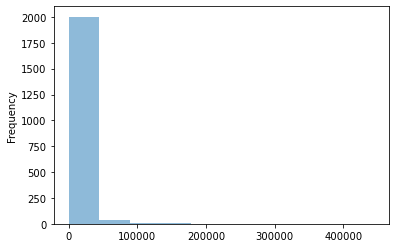

In [82]:
exp_df['LB'].plot.hist(alpha=0.5)

In [83]:
for col in exp_df.columns:
    exp_df[col] = exp_df[col] / sum(exp_df[col])
    exp_df[col] = exp_df[col] * 1e6
    exp_df[col] = np.log10(exp_df[col])
exp_df.head()

,42C glucose,Acetate,Fructose,Fumarate,Galactose,Glucosamine,Glucose,Glycerol,Glycerol + AA,LB,Mannose,Osmotic-stress glucose,Pyruvate,Succinate,Xylose,Chemostat u=0.12,Chemostat u=0.20,Chemostat u=0.35,Chemostat u=0.5,pH6 glucose
Gene,,,,,,,,,,,,,,,,,,,,
rpoC,2.879362,2.758544,2.943026,2.747771,2.776118,2.854829,2.741248,2.788555,2.804975,2.935141,2.878261,2.629650,2.815463,2.794840,2.868232,2.986259,3.008309,2.992261,3.023185,2.784624
rpoB,2.971093,2.845176,3.009955,2.864590,2.872680,2.936218,2.894848,2.908436,2.867355,3.028790,2.963903,2.790295,2.949216,2.939329,2.955233,3.047660,3.053653,3.043443,3.063442,2.866446
acnB,2.963902,3.778861,3.231803,3.649451,3.532119,3.472648,3.177993,3.367652,3.395708,3.300064,3.564527,2.727287,3.594041,3.644371,3.134052,3.647923,3.682208,3.707808,3.540532,2.928315
purL,2.554317,2.577746,2.669436,2.675890,2.618399,2.626278,2.687710,2.650036,2.520507,1.994140,2.593167,2.397841,2.811988,2.635110,2.543861,2.595134,2.633818,2.639276,2.702648,2.493506
gltB,2.753016,2.554462,2.874572,2.467063,2.567901,2.630325,2.753638,2.677730,1.965687,1.861220,2.664354,2.198830,2.607411,2.544424,2.705410,2.648765,2.715373,2.693286,2.709468,2.696086


**Double checking the work**

Just making sure somethings add up here

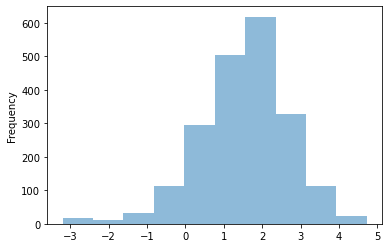

In [84]:
exp_df['LB'].plot.hist(alpha=0.5)

**Kill any completely identical columns, these must be bugs on the data end and even though I could in theory keep one, their growth rate value is unclear (since it differs)**

In [85]:
temp_corr = exp_df.corr(method='spearman')

In [86]:
temp_df = pd.DataFrame(
    np.where(np.equal(*np.indices(temp_corr.shape)), np.nan, temp_corr.values),
    temp_corr.index, temp_corr.columns
)
print(temp_df.shape)
temp_df.head()

(20, 20)


,42C glucose,Acetate,Fructose,Fumarate,Galactose,Glucosamine,Glucose,Glycerol,Glycerol + AA,LB,Mannose,Osmotic-stress glucose,Pyruvate,Succinate,Xylose,Chemostat u=0.12,Chemostat u=0.20,Chemostat u=0.35,Chemostat u=0.5,pH6 glucose
42C glucose,NaN,0.954475,0.975548,0.956723,0.955055,0.962861,0.973317,0.965765,0.933876,0.901281,0.965963,0.969707,0.961055,0.965231,0.978263,0.923002,0.931467,0.938082,0.954881,0.972199
Acetate,0.954475,NaN,0.965569,0.989072,0.974273,0.982748,0.966986,0.980009,0.947888,0.915441,0.980326,0.948529,0.980823,0.978417,0.962095,0.965368,0.971783,0.973644,0.978258,0.949948
Fructose,0.975548,0.965569,NaN,0.971829,0.965252,0.975855,0.978938,0.979873,0.947335,0.912537,0.983142,0.957508,0.976805,0.984090,0.982129,0.936472,0.948280,0.957314,0.974791,0.958667
Fumarate,0.956723,0.989072,0.971829,NaN,0.978360,0.988347,0.971067,0.987650,0.956270,0.921005,0.986165,0.946335,0.987414,0.987557,0.964546,0.967428,0.976354,0.980497,0.983958,0.943363
Galactose,0.955055,0.974273,0.965252,0.978360,NaN,0.974945,0.950818,0.971112,0.928658,0.892988,0.982649,0.948147,0.967746,0.981308,0.960592,0.968314,0.971518,0.968936,0.966261,0.948078


In [87]:
temp_df[temp_df.values==1]

,42C glucose,Acetate,Fructose,Fumarate,Galactose,Glucosamine,Glucose,Glycerol,Glycerol + AA,LB,Mannose,Osmotic-stress glucose,Pyruvate,Succinate,Xylose,Chemostat u=0.12,Chemostat u=0.20,Chemostat u=0.35,Chemostat u=0.5,pH6 glucose


# Construct a third `dataframe` containing expression data summary stats

In [88]:
exp_summary_df = exp_df.apply(pd.DataFrame.describe, axis=1)

In [89]:
col_listy = []
for col in exp_summary_df.columns:
    if '%' not in col:
        col_listy.append(col)
    else:
        col_listy.append(col.replace('%', '_percentile'))
print(col_listy)
exp_summary_df.columns = col_listy

['count', 'mean', 'std', 'min', '25_percentile', '50_percentile', '75_percentile', 'max']


In [90]:
exp_summary_df['cv'] = exp_summary_df['std']/exp_summary_df['mean']
exp_summary_df['noise'] = exp_summary_df['std'].pow(2)/exp_summary_df['mean'].pow(2)

In [91]:
slopes = []
pearsons = []
spearmans = []
for gene in exp_summary_df.index:
    a, b, c, d, e = stats.linregress(exp_df.loc[gene], meta_df['Growth Rate (1/hr)'])
    slopes.append(a)
    pearsons.append(c)
    rho, p = stats.spearmanr(exp_df.loc[gene], meta_df['Growth Rate (1/hr)'])
    spearmans.append(rho)
    
exp_summary_df['lin_slope'] = slopes
exp_summary_df['lin_r'] = pearsons
exp_summary_df['spearmans_rho'] = spearmans

# Save some files

In [92]:
meta_df['Simple_sample_id'] = meta_df['Growth condition']
print(exp_df.shape)
print(meta_df.shape)
print(exp_summary_df.shape)
exp_df.to_csv('../Data/processed_data/processed_expression_ecoli_PROTEIN.tsv', sep='\t')
meta_df.to_csv('../Data/processed_data/processed_metadata_ecoli_PROTEIN.tsv', sep='\t')
exp_summary_df.to_csv('../Data/processed_data/processed_expression_summary_ecoli_PROTEIN.tsv', sep='\t')

(2052, 20)
(20, 13)
(2052, 13)
